In [ ]:

import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

from train_mlp_numpy import train as numpy_train
import pytorch_train_mlp

import types  

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

%matplotlib inline

np.random.seed(42)


In [ ]:

def generate_moons_dataset(n_samples=1000, noise=0.2, random_state=42, test_size=0.2):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def generate_circles_dataset(n_samples=1000, noise=0.1, factor=0.5,
                             random_state=42, test_size=0.2):
    X, y = make_circles(n_samples=n_samples, noise=noise,
                        factor=factor, random_state=random_state)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def generate_blobs_dataset(n_samples=1000, centers=2, cluster_std=3.0,
                           random_state=42, test_size=0.2):
    X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=2,
                      cluster_std=cluster_std, random_state=random_state)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


In [ ]:

from itertools import cycle

def plot_dataset(X_train, y_train, X_test, y_test, title="Dataset"):
    classes = np.unique(np.concatenate([y_train, y_test]))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    markers = ['o', '^', 's', 'x', 'D']

    color_cyc = cycle(colors)
    marker_cyc = cycle(markers)

    class_to_style = {}
    for c in classes:
        class_to_style[c] = (next(color_cyc), next(marker_cyc))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax_train, ax_test = axes

    for c in classes:
        col, mark = class_to_style[c]
        ax_train.scatter(X_train[y_train == c, 0],
                         X_train[y_train == c, 1],
                         c=col, marker=mark, edgecolors='k', alpha=0.8,
                         label=f"class {c}")
    ax_train.set_title("Training set")
    ax_train.set_xlabel("x1")
    ax_train.set_ylabel("x2")
    ax_train.legend()

    for c in classes:
        col, mark = class_to_style[c]
        ax_test.scatter(X_test[y_test == c, 0],
                        X_test[y_test == c, 1],
                        c=col, marker=mark, edgecolors='k', alpha=0.8,
                        label=f"class {c}")
    ax_test.set_title("Test set")
    ax_test.set_xlabel("x1")
    ax_test.set_ylabel("x2")
    ax_test.legend()

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def compute_eval_steps(max_steps, eval_freq):
    steps = list(range(0, max_steps, eval_freq))
    if (max_steps - 1) % eval_freq != 0:
        steps.append(max_steps - 1)
    return steps


def plot_learning_curves(eval_steps, numpy_results, torch_results, dataset_name=""):
    plt.figure(figsize=(5,3))

    # Accuracy
    plt.plot(eval_steps, numpy_results["train_accuracies"],
             label="NumPy train", linewidth=2)
    plt.plot(eval_steps, numpy_results["test_accuracies"],
             label="NumPy test", linewidth=2)
    plt.plot(eval_steps, torch_results["train_accuracies"],
             "--", label="PyTorch train")
    plt.plot(eval_steps, torch_results["test_accuracies"],
             "--", label="PyTorch test")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy vs Epoch ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:

def train_numpy_and_pytorch(
    X_train, y_train_labels, X_test, y_test_labels,
    dnn_hidden_units="20",
    learning_rate=1e-2,
    max_steps=300,
    eval_freq=10
):


    num_classes = np.unique(y_train_labels).size
    y_train_onehot = np.eye(num_classes)[y_train_labels]
    y_test_onehot = np.eye(num_classes)[y_test_labels]

    numpy_results = numpy_train(
        dnn_hidden_units=dnn_hidden_units,
        learning_rate=learning_rate,
        max_steps=max_steps,
        eval_freq=eval_freq,
        batch_size='full',            
        X_train=X_train,
        y_train=y_train_onehot,
        X_test=X_test,
        y_test=y_test_onehot
    )

    pytorch_train_mlp.FLAGS = types.SimpleNamespace(
        dnn_hidden_units=dnn_hidden_units,
        learning_rate=learning_rate,
        max_steps=max_steps,
        eval_freq=eval_freq
    )

    torch_results = pytorch_train_mlp.train(
        X_train=X_train,
        y_train=y_train_labels,
        X_test=X_test,
        y_test=y_test_labels
    )

    return numpy_results, torch_results


In [ ]:
def run_experiment(
    dataset_name,
    dataset_generator,
    dnn_hidden_units="20",
    learning_rate=1e-2,
    max_steps=300,
    eval_freq=10
):


    print(f"=== Dataset: {dataset_name} ===")

    X_train, X_test, y_train, y_test = dataset_generator()
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    print(f"Input dimension: {X_train.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_train))}\n")

    plot_dataset(X_train, y_train, X_test, y_test,
                 title=f"{dataset_name} dataset")

    numpy_results, torch_results = train_numpy_and_pytorch(
        X_train, y_train, X_test, y_test,
        dnn_hidden_units=dnn_hidden_units,
        learning_rate=learning_rate,
        max_steps=max_steps,
        eval_freq=eval_freq
    )

    eval_steps = compute_eval_steps(max_steps, eval_freq)

    plot_learning_curves(eval_steps, numpy_results, torch_results,
                         dataset_name=dataset_name)

    final_numpy_train_acc = numpy_results["train_accuracies"][-1]
    final_numpy_test_acc = numpy_results["test_accuracies"][-1]
    final_torch_train_acc = torch_results["train_accuracies"][-1]
    final_torch_test_acc = torch_results["test_accuracies"][-1]

    print(f"Final NumPy  train accuracy: {final_numpy_train_acc:.2f}%")
    print(f"Final NumPy  test  accuracy: {final_numpy_test_acc:.2f}%")
    print(f"Final PyTorch train accuracy: {final_torch_train_acc:.2f}%")
    print(f"Final PyTorch test  accuracy: {final_torch_test_acc:.2f}%")

    return numpy_results, torch_results


=== Dataset: Moons ===
Train size: 800, Test size: 200
Input dimension: 2
Number of classes: 2



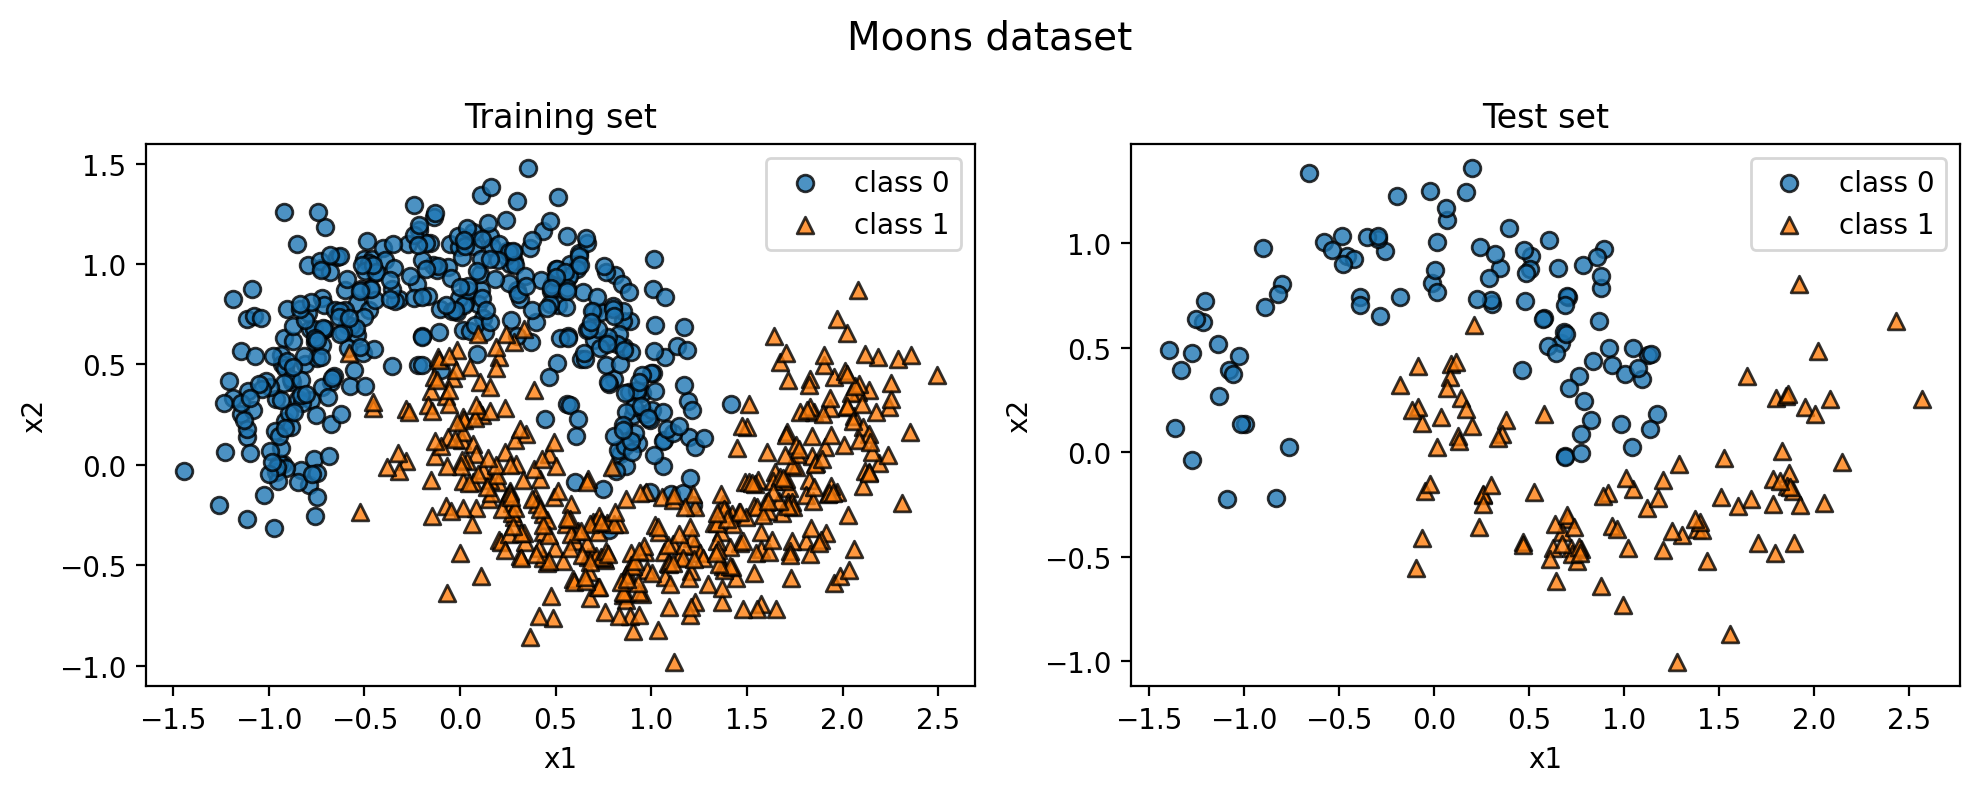

Using provided dataset...
Using Batch Gradient Descent (full dataset)
Training samples: 800, Batches per epoch: 1
Starting training...
Step    0: Train Loss = 0.6719, Test Loss = 0.6727, Train Acc = 80.88%, Test Acc = 77.00%
Step   50: Train Loss = 0.6586, Test Loss = 0.6603, Train Acc = 82.00%, Test Acc = 79.00%
Step  100: Train Loss = 0.6430, Test Loss = 0.6460, Train Acc = 82.50%, Test Acc = 79.50%
Step  150: Train Loss = 0.6251, Test Loss = 0.6296, Train Acc = 81.88%, Test Acc = 79.00%
Step  200: Train Loss = 0.6045, Test Loss = 0.6111, Train Acc = 81.00%, Test Acc = 78.00%
Step  250: Train Loss = 0.5819, Test Loss = 0.5906, Train Acc = 80.62%, Test Acc = 77.00%
Step  300: Train Loss = 0.5578, Test Loss = 0.5688, Train Acc = 80.75%, Test Acc = 77.50%
Step  350: Train Loss = 0.5330, Test Loss = 0.5462, Train Acc = 80.88%, Test Acc = 78.00%
Step  400: Train Loss = 0.5085, Test Loss = 0.5236, Train Acc = 81.62%, Test Acc = 78.00%
Step  450: Train Loss = 0.4848, Test Loss = 0.5016, Tra

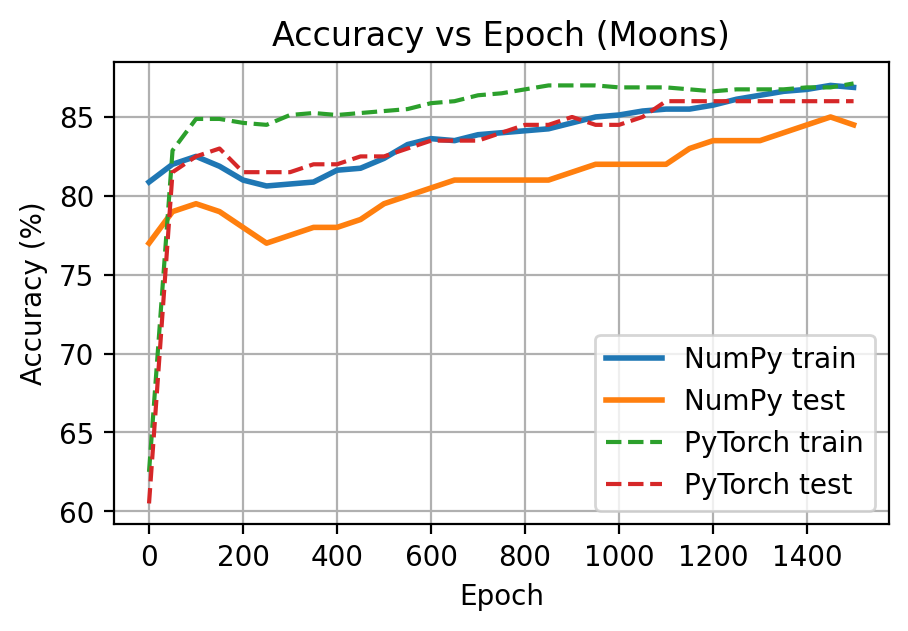

Final NumPy  train accuracy: 86.88%
Final NumPy  test  accuracy: 84.50%
Final PyTorch train accuracy: 87.12%
Final PyTorch test  accuracy: 86.00%


In [ ]:
HIDDEN_UNITS = "20"    
LEARNING_RATE = 1e-2
MAX_STEPS = 1500        
EVAL_FREQ = 50

results_moons_numpy, results_moons_torch = run_experiment(
    dataset_name="Moons",
    dataset_generator=generate_moons_dataset,
    dnn_hidden_units=HIDDEN_UNITS,
    learning_rate=LEARNING_RATE,
    max_steps=MAX_STEPS,
    eval_freq=EVAL_FREQ
)


=== Dataset: Circles ===
Train size: 800, Test size: 200
Input dimension: 2
Number of classes: 2



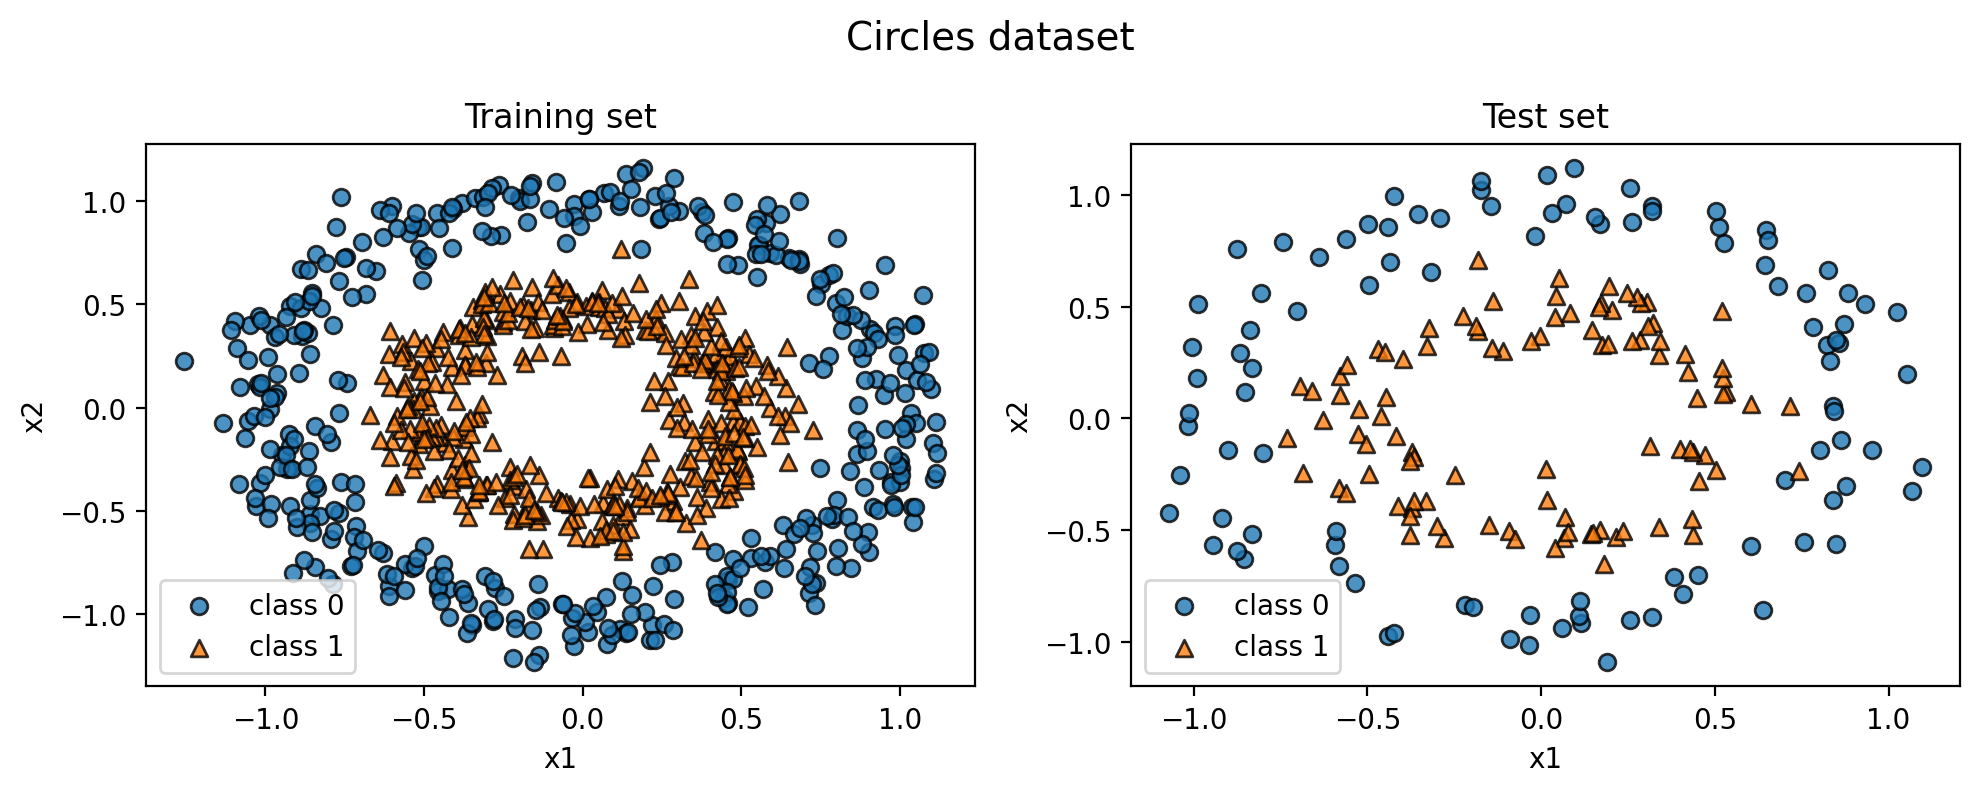

Using provided dataset...
Using Batch Gradient Descent (full dataset)
Training samples: 800, Batches per epoch: 1
Starting training...
Step    0: Train Loss = 0.6986, Test Loss = 0.6962, Train Acc = 50.50%, Test Acc = 49.50%
Step   50: Train Loss = 0.6976, Test Loss = 0.6955, Train Acc = 48.38%, Test Acc = 46.50%
Step  100: Train Loss = 0.6966, Test Loss = 0.6948, Train Acc = 47.00%, Test Acc = 47.00%
Step  150: Train Loss = 0.6957, Test Loss = 0.6942, Train Acc = 46.50%, Test Acc = 47.00%
Step  200: Train Loss = 0.6948, Test Loss = 0.6935, Train Acc = 46.12%, Test Acc = 47.50%
Step  250: Train Loss = 0.6939, Test Loss = 0.6929, Train Acc = 47.00%, Test Acc = 47.50%
Step  300: Train Loss = 0.6931, Test Loss = 0.6923, Train Acc = 47.12%, Test Acc = 47.50%
Step  350: Train Loss = 0.6923, Test Loss = 0.6917, Train Acc = 48.12%, Test Acc = 48.00%
Step  400: Train Loss = 0.6915, Test Loss = 0.6911, Train Acc = 49.00%, Test Acc = 49.50%
Step  450: Train Loss = 0.6906, Test Loss = 0.6906, Tra

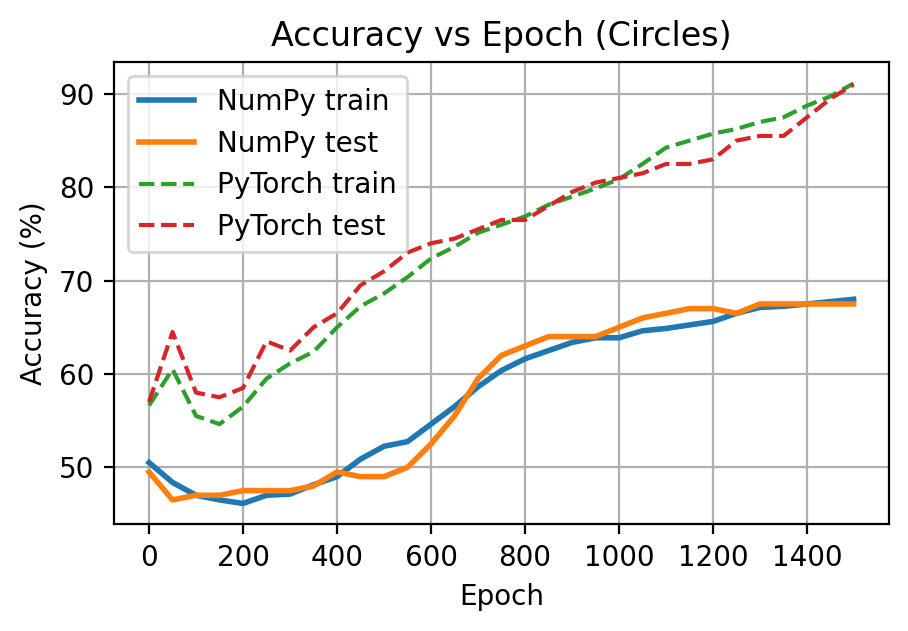

Final NumPy  train accuracy: 68.00%
Final NumPy  test  accuracy: 67.50%
Final PyTorch train accuracy: 91.12%
Final PyTorch test  accuracy: 91.00%


In [ ]:
results_circles_numpy, results_circles_torch = run_experiment(
    dataset_name="Circles",
    dataset_generator=generate_circles_dataset,
    dnn_hidden_units=HIDDEN_UNITS,
    learning_rate=LEARNING_RATE,
    max_steps=MAX_STEPS,
    eval_freq=EVAL_FREQ
)


=== Dataset: Blobs ===
Train size: 800, Test size: 200
Input dimension: 2
Number of classes: 2



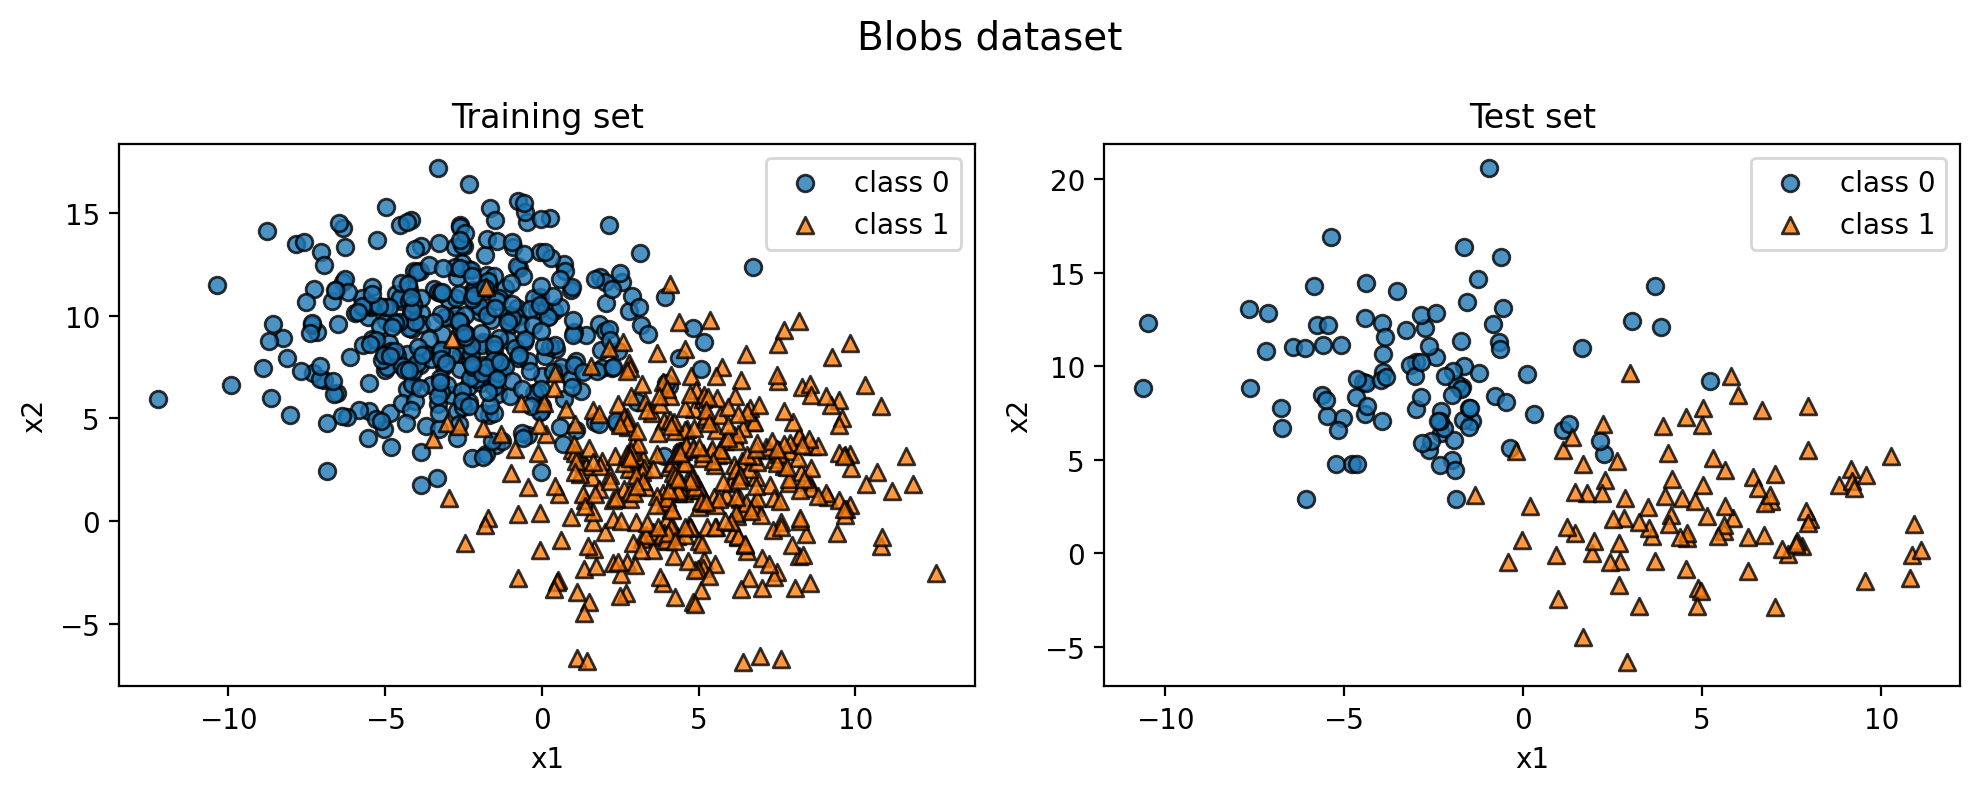

Using provided dataset...
Using Batch Gradient Descent (full dataset)
Training samples: 800, Batches per epoch: 1
Starting training...
Step    0: Train Loss = 0.5935, Test Loss = 0.5804, Train Acc = 87.00%, Test Acc = 88.00%
Step   50: Train Loss = 0.3329, Test Loss = 0.3100, Train Acc = 91.75%, Test Acc = 91.50%
Step  100: Train Loss = 0.2259, Test Loss = 0.2009, Train Acc = 92.88%, Test Acc = 95.00%
Step  150: Train Loss = 0.1882, Test Loss = 0.1589, Train Acc = 93.75%, Test Acc = 94.50%
Step  200: Train Loss = 0.1731, Test Loss = 0.1405, Train Acc = 93.75%, Test Acc = 95.00%
Step  250: Train Loss = 0.1656, Test Loss = 0.1308, Train Acc = 93.75%, Test Acc = 95.00%
Step  300: Train Loss = 0.1612, Test Loss = 0.1250, Train Acc = 93.75%, Test Acc = 95.00%
Step  350: Train Loss = 0.1584, Test Loss = 0.1211, Train Acc = 93.88%, Test Acc = 95.00%
Step  400: Train Loss = 0.1562, Test Loss = 0.1184, Train Acc = 93.88%, Test Acc = 95.50%
Step  450: Train Loss = 0.1546, Test Loss = 0.1163, Tra

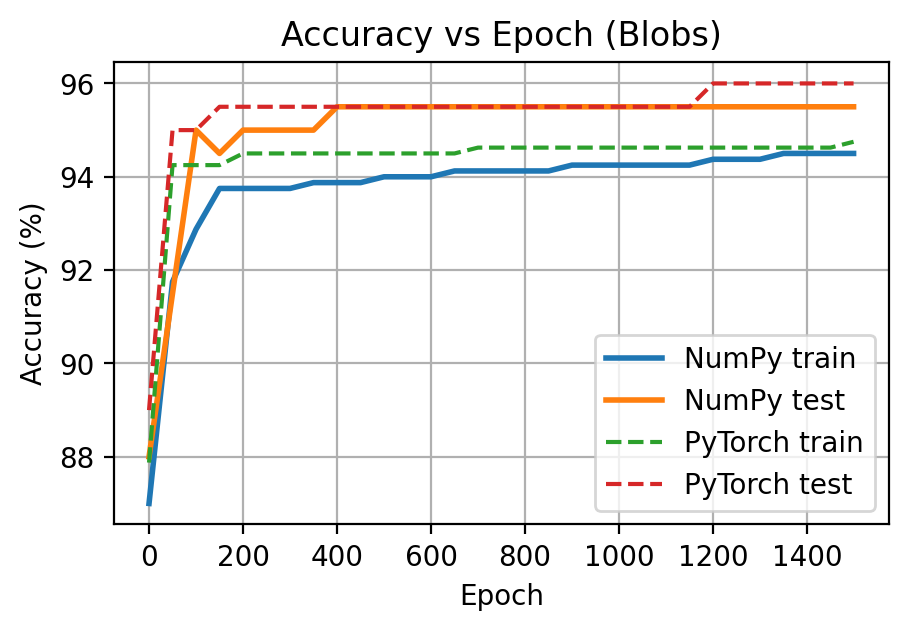

Final NumPy  train accuracy: 94.50%
Final NumPy  test  accuracy: 95.50%
Final PyTorch train accuracy: 94.75%
Final PyTorch test  accuracy: 96.00%


In [ ]:
results_blobs_numpy, results_blobs_torch = run_experiment(
    dataset_name="Blobs",
    dataset_generator=generate_blobs_dataset,
    dnn_hidden_units=HIDDEN_UNITS,
    learning_rate=LEARNING_RATE,
    max_steps=MAX_STEPS,
    eval_freq=EVAL_FREQ
)
